# Welcome to the Multi Object or Multi Leaf Tutorial
Made by: Katie Murphy
Updated: May 16, 2023

Updated August 16, 2023 by Haley Schuhl 

# Section 1: Importing Image and Libraries

First, import the necessary Python packages. 

In [1]:
# Set the notebook display method
# If widget is not working, then change to inline
%matplotlib widget

In [2]:
# Import libraries
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__

'0.0.0'

Next, initialize your workflow inputs. It's possible to just directly read a sample image, but this step sets up a workflow to be used later in batch processing/running in parallel. Remember, always keep your raw images separate from your newly processed images! 

## Input/Output variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later. Remember, always keep your raw images separate from your newly processed images!

In [3]:
# Input/output options
args = WorkflowInputs(
    images=["./imgs/O_HLP_1_P_LEAF_2022-12-07_09_32_15.jpg"],
    names="image1",
    result="example_results_oneimage_file.json",
    outdir=".",
    writeimg=False,
    debug="plot"
    )

In [4]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

## Read the input image

### Reading images into your environment using *pcv.readimage()*
Inputs:
   * filename = Image file to be read in
   * mode     = How the image will be read into the notebook; either 'native' (default), 'rgb', 'gray', 'csv', or 'envi'

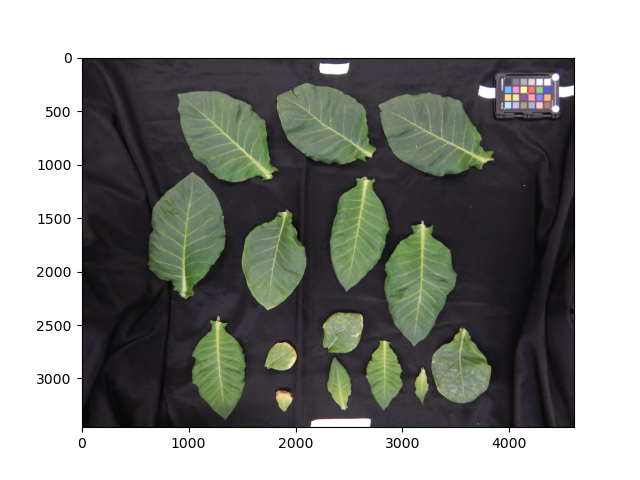

In [5]:
img, path, filename = pcv.readimage(filename=args.image1)

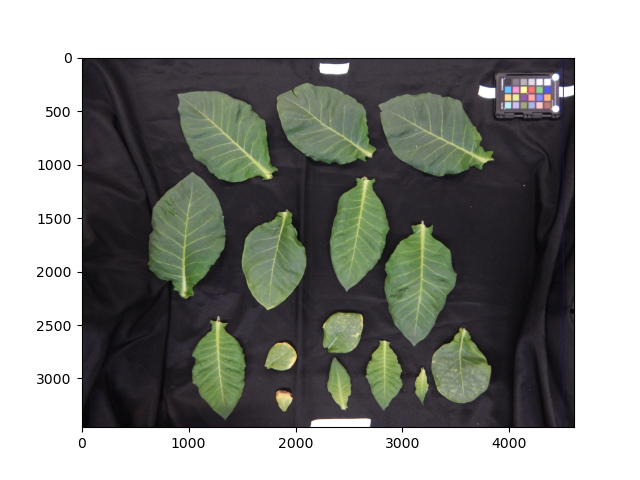

In [6]:
# Crop image if necessary. This is optional. 
crop_img = pcv.crop(img=img, x=0, y=0, h=3500, w=4500)

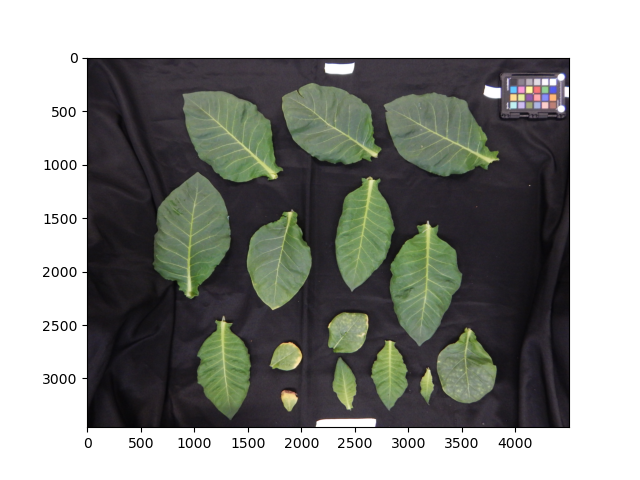

In [7]:
# If your image is not straight, rotate it. Here our image is straight becasue our camera was 
# on a flat surface, so we will rotate 0 degrees (unchanged). 

rotate_img = pcv.transform.rotate(crop_img, 0, False)

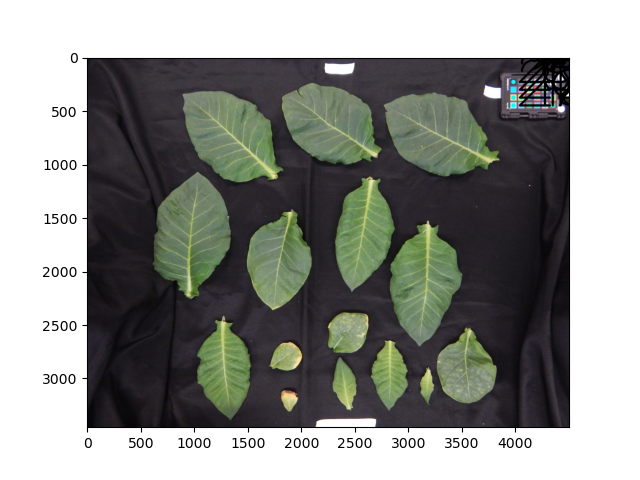

In [8]:
#First, find the color card. 
card_mask = pcv.transform.detect_color_card(rgb_img=rotate_img)

In [9]:
# Make a color card matrix 

headers, card_matrix = pcv.transform.get_color_matrix(rgb_img=rotate_img, mask=card_mask)

In [10]:
# Define the standard color card matrix, we know what the colors of those chips should be in an "ideal" image, 
# so we will correct to those values as the TARGET c
# Look at where your white chip is in the image to determine which position your card is in (pos)
# This function is undergoing development and will eventually be deprecated to make color card segmentation simpler
# Position 3 is the only value that will yield a color corrected image

std_color_matrix = pcv.transform.std_color_matrix (pos=3)

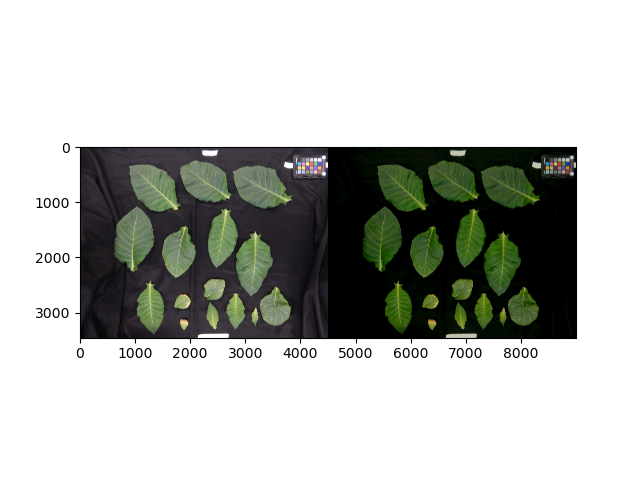

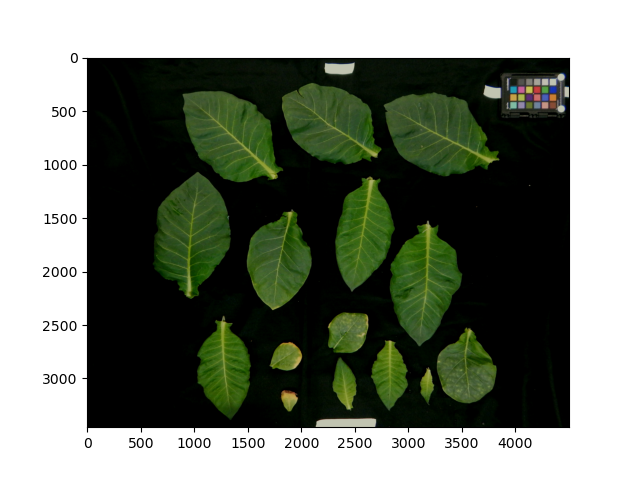

In [11]:
# Color correct your image to the standard values
# look at the image - does the color look good? 
# If it looks crazy, you probably don't have the card found well and need to go back and 
# define the start and spacing for the card

img_cc = pcv.transform.affine_color_correction(rgb_img=rotate_img, source_matrix=card_matrix, 
                                               target_matrix=std_color_matrix)
pcv.plot_image(img_cc)

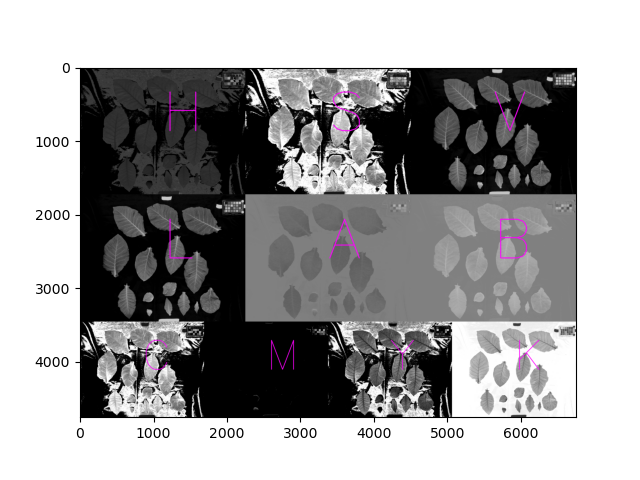

In [12]:
# Update params related to plotting so we can see better 
pcv.params.text_size=50
pcv.params.text_thickness=25


#Look at the colorspace - which of these looks the best for masking? 
# Which channel makes the plant look most distinct from the background?
colorspace_img = pcv.visualize.colorspaces(rgb_img=img_cc, original_img=False)

In [13]:
#If you want to save your color corrected image, do so here. Do NOT save over your raw image. 
# We are saving as a temporary image here becasue we want to use it for thresholding. 

pcv.print_image(img_cc, filename = "./color_corrected_img_temp.png")

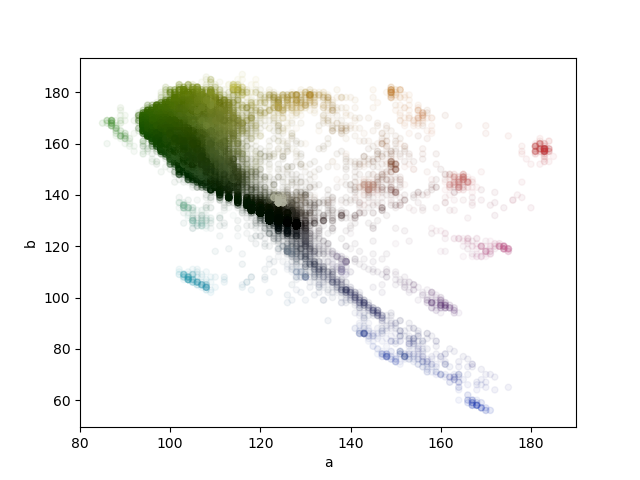

In [14]:
#Visualize all the colors to make decisions on how to threshold. I picked the two channels from the colorspace above that looked distinct

color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs=["./color_corrected_img_temp.png"], 
                                                 x_channel = "a", y_channel ="b" )



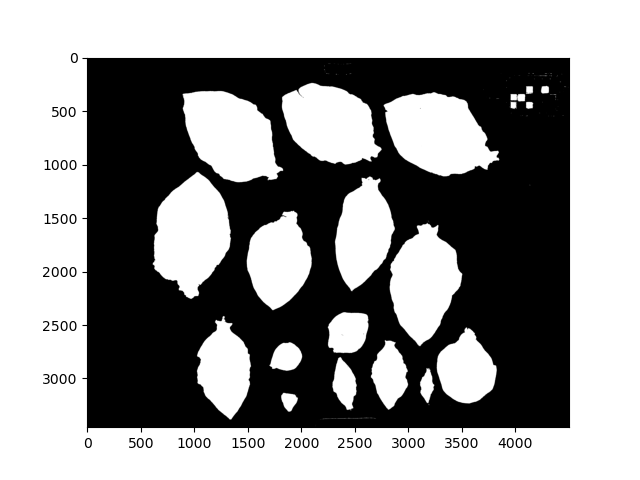

In [15]:
# Threshold your image by choosing points in the plot that will separate the green plant pixels from everything else. 
# It will draw a line between your two points and take every pixel "above" (if set to true). Do you get all of the plant?

thresh1 = pcv.threshold.dual_channels(rgb_img = img_cc, x_channel = "a", y_channel = "b", 
                                      points = [(100,120),(130,160)], above=True)

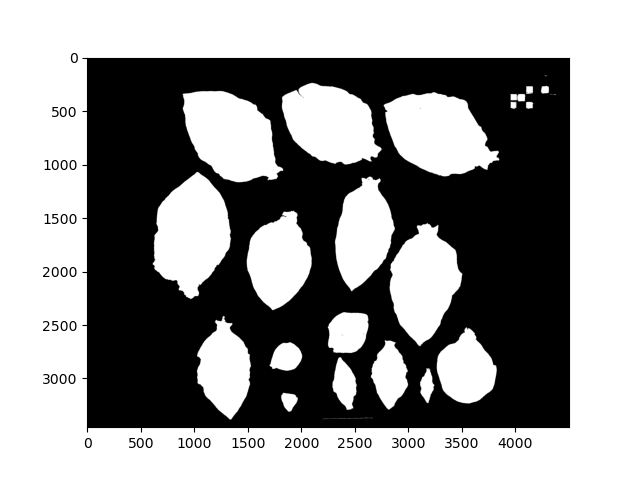

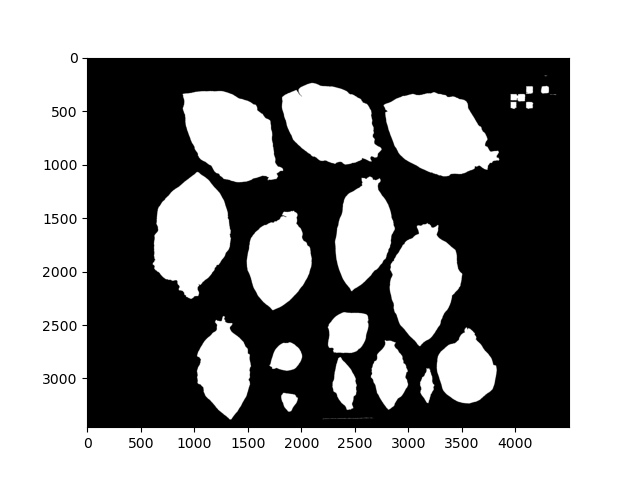

In [16]:
# Fill in small objects if below the "size" threshold
a_fill_image = pcv.fill(bin_img=thresh1, size=50)
# Flood fill any holes in the leaves (false negative pixels)
a_fill_image = pcv.fill_holes(a_fill_image)


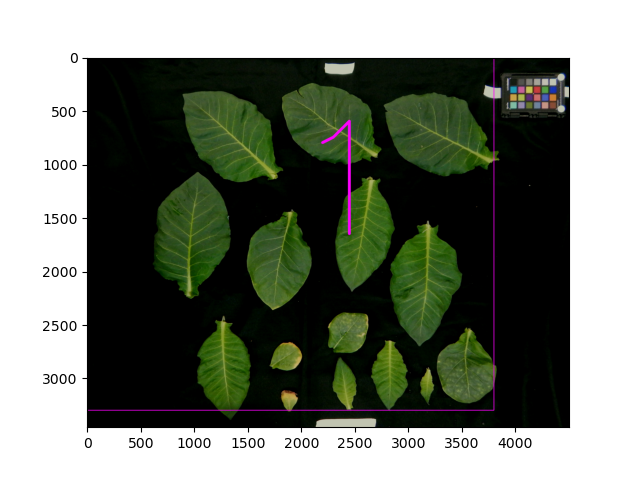

In [17]:
# Define the region of interest (ROI). 
# This should include  all of your leaves or all of your plants, but not you color card or other noise. 

roi1 = pcv.roi.rectangle(img=img_cc, x=0, y=0, h=3300, w=3800)



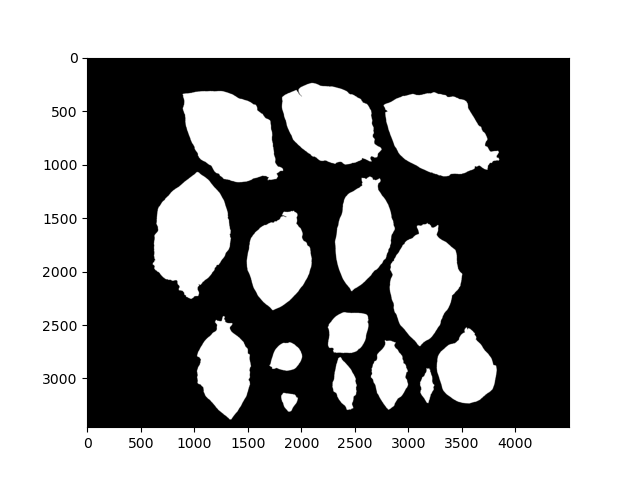

In [18]:
# Make a new filtered mask that only keeps the leaves in your ROI and not objects outside of the ROI
# We have set to partial here so that if a leaf extends outside of your ROI it will still be selected. Switch to "cutto" if you have other plants that are getting selected on accident

# Inputs:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

kept_mask  = pcv.roi.filter(mask=a_fill_image, roi=roi1, roi_type='partial')


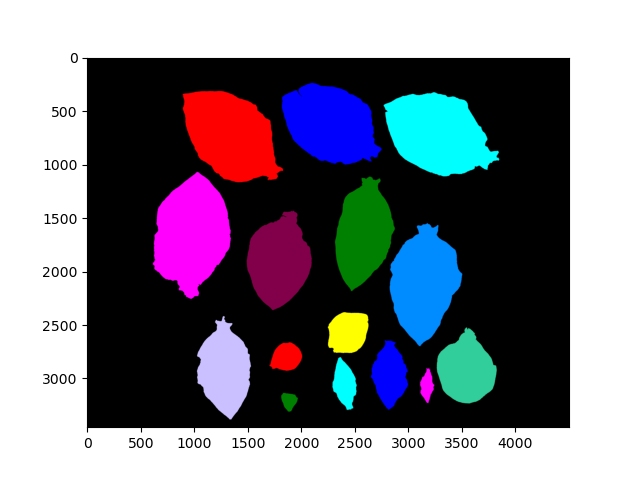

In [19]:
#Label the objects in your region of interest and number them
#Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask so that they are separate or it will treat them as a single object

#    mask            = the clean mask you made above after making your ROI

labeled_objects, n_obj = pcv.create_labels(mask=kept_mask)

# This example has one color per leaf, so this would be good enough to do per-replicate trait extraction. 

## Using pcv.Points() to gather center coordinates of ROIs

### There are multiple ways to get your leaves. If you are finding this single, large ROI is not getting your plants individually, try another method.  Here, we will use the interactive tool to click on locations to make ROIs. This is a good method if you cannot get a clean ROI using single or multi. This method cannot be run in paralell, only in a jupyter notebook, because you cannot "interact" in parallel. 

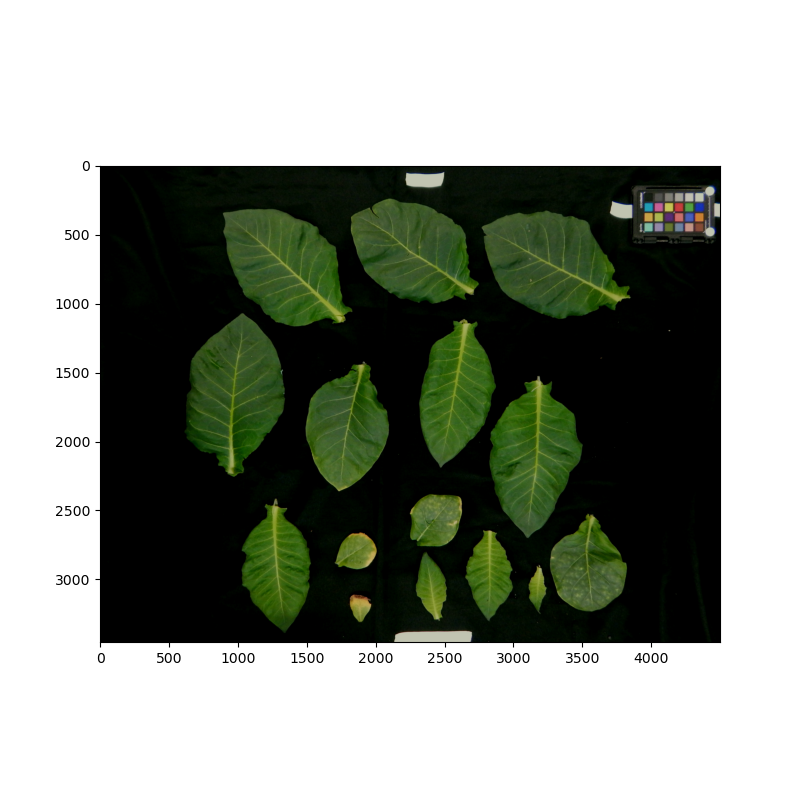

In [20]:
# collect points for center of ROIs by clicking on each leaf. 
marker = pcv.Points(img_cc, figsize=(8,8))


Now that you have selected center coordinates for each leaf, we are going to use those coordinates to generate ROIs for each leaf. In the block below, you will see that there is an **ifelse** statement being used. This code is only necessary if *marker* is not populated by values. We have hard-coded coordinates into a variable named *tutorial_coords* for the leaves in the tutorial image so that the function will work regardless of whether coordinates have been stored in *marker*. This 

[(1298, 724), (2314, 608), (3287, 680), (950, 1602), (1770, 1870), (2583, 1609), (3156, 2132), (3497, 2821), (3164, 3068), (2757, 2981), (2416, 2473), (2380, 3024), (1850, 2785), (1864, 3177), (1269, 2901)]


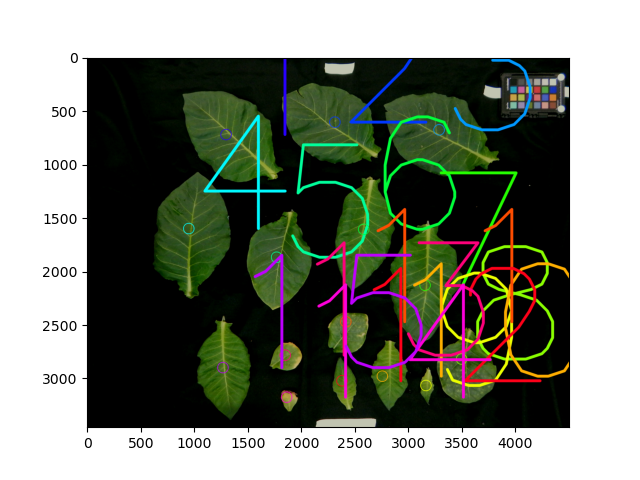

In [21]:
tutorial_coords = [(1298, 724), (2314, 608), (3287, 680), (950, 1602), (1770, 1870), (2583, 1609), (3156, 2132), (3497, 2821), (3164, 3068), (2757, 2981), (2416, 2473), (2380, 3024), (1850, 2785), (1864, 3177), (1269, 2901)]
print(tutorial_coords)

# Create ROIs based on the selected points
# Your ROIs will show up as blue circles here. 
# roi2 = pcv.roi.multi(img=img_cc, coord=marker.points, radius=50)

if len(marker.points) > 0:
    roi2 = pcv.roi.multi(img=img_cc, coord=marker.points, radius=50)
else:
    roi2 = pcv.roi.multi(img=img_cc, coord=tutorial_coords, radius=50)


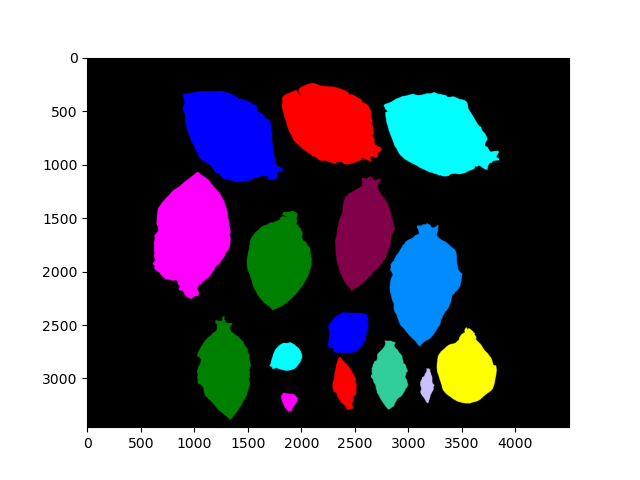

In [22]:
# Label the objects in your region of interest and number them
# Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask 
# so that they are separate or it will treat them as a single object


labeled_objects2, n_obj2 = pcv.create_labels(mask=a_fill_image, rois=roi2, roi_type="partial")


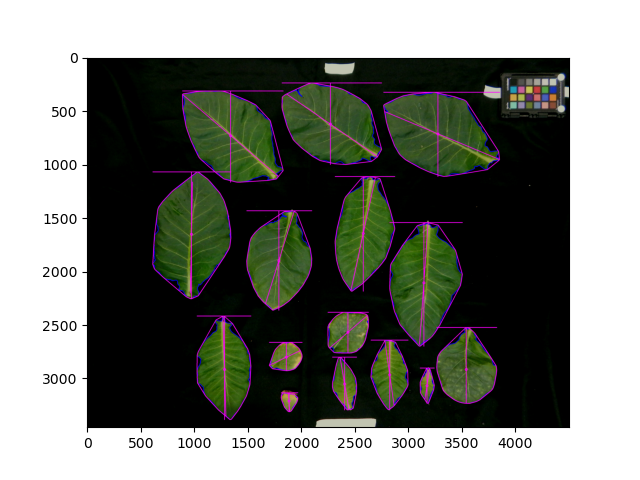

In [23]:
############### Analysis ################ 
  
# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 

analysis_image = pcv.analyze.size(img=img_cc, labeled_mask=labeled_objects, n_labels=n_obj)


In [24]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)


color_histogram = pcv.analyze.color(rgb_img=img_cc, labeled_mask=labeled_objects, n_labels=n_obj, colorspaces='hsv')


alt.FacetChart(...)

In [25]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: pcv.analyze.bound_horizontal, pcv.analyze.bound_vertical, pcv.analyze.color, pcv.analyze.grayscale, pcv.analyze.size, 
# pcv.analyze.yii, pcv.report_size_marker_area, pcv.watershed_segmentation. If no functions have been run, it will print an empty text file 

#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename=args.result)
